### DSAI3301: Netflix Top 10 Inferential Analysis (Primary Genre Approach + Exploded Tags for Regression)

This notebook demonstrates a step-by-step inferential analysis using a clean genre-based strategy:
We will:
1. Load and explore the dataset
2. Understand weekly appearances vs. cumulative popularity
3. Aggregate to one record per title and extract primary genre + tag dummies
4. Plan and justify visualizations
5. Generate visualizations
6. Perform hypothesis tests:
- a. Chi‑Square (primary genre vs. popularity band)
- b. ANOVA (IMDb rating vs. primary genre)
- c. Regression (IMDb rating & tags → cumulative weeks)
7. Interpret results and extract business insights


### 1. Load and Explore the Dataset

In this cell we load the CSV file, convert types, and inspect basic properties:

In [2]:
import pandas as pd


def load_data(path: str) -> pd.DataFrame:
    """
    Load the Netflix Top 10 dataset and coerce types:
      - week → datetime
      - imdb_rating → float
      - cumulative_weeks_in_top_10 → int
    Returns a pandas DataFrame.
    """
    df = pd.read_csv(path)
    df['week'] = pd.to_datetime(df['week'], dayfirst=True)
    df['imdb_rating'] = pd.to_numeric(df['imdb_rating'], errors='coerce')
    df['cumulative_weeks_in_top_10'] = pd.to_numeric(
        df['cumulative_weeks_in_top_10'], errors='coerce').fillna(0).astype(int)
    return df


# Load dataset
df = load_data('Datasets/netflix_omdb_dataset.csv')

# Inspect shape, dtypes, and sample rows
print(f"Dataset shape: {df.shape}")
print(df.dtypes)

df.head(40)


Dataset shape: (8160, 15)
week                          datetime64[ns]
category                              object
weekly_rank                            int64
show_title                            object
season_title                          object
weekly_hours_viewed                    int64
runtime                              float64
weekly_views                         float64
cumulative_weeks_in_top_10             int32
is_staggered_launch                     bool
is_live_title                        float64
genre                                 object
origin_country                        object
release_year                          object
imdb_rating                          float64
dtype: object


,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,is_live_title,genre,origin_country,release_year,imdb_rating
0,2025-05-25,Films (English),1,Fear Street: Prom Queen,NaN,16000000,1.5000,10700000.0,1,False,0.0,"Horror, Mystery, Thriller",United States,2025,5.1
1,2025-05-25,Films (English),2,Puss in Boots: The Last Wish,NaN,14800000,1.7000,8700000.0,4,False,0.0,"Animation, Action, Adventure",United States,2022,7.8
2,2025-05-25,Films (English),3,Nonnas,NaN,16000000,1.9000,8400000.0,3,False,0.0,Comedy,United States,2025,6.9
3,2025-05-25,Films (English),4,Untold: The Fall of Favre,NaN,7300000,1.0667,6800000.0,1,False,0.0,"Crime, Sport",United States,2025,6.0
4,2025-05-25,Films (English),5,Instant Family,NaN,10600000,1.9833,5300000.0,2,False,0.0,"Comedy, Drama",United States,2018,7.3
5,2025-05-25,Films (English),6,Havoc,NaN,9000000,1.7833,5000000.0,5,False,0.0,"Action, Crime, Drama",United Kingdom,2025,NaN
6,2025-05-25,Films (English),7,A Deadly American Marriage,NaN,7500000,1.7167,4400000.0,3,False,0.0,"Documentary, Crime",United Kingdom,2025,NaN
7,2025-05-25,Films (English),8,Dr. Seuss' The Cat in the Hat,NaN,5500000,1.3667,4000000.0,1,False,0.0,"Animation, Short",United States,2012,NaN
8,2025-05-25,Films (English),9,Air Force Elite: Thunderbirds,NaN,5700000,1.5167,3800000.0,1,False,0.0,Documentary,United States,2025,NaN
9,2025-05-25,Films (English),10,The Wild Robot,NaN,5600000,1.7000,3300000.0,1,False,0.0,"Animation, Sci-Fi",United States,2024,8.2


### 2. Weekly Appearances vs Cumulative Popularity

- Each row is a weekly entry. The cumulative_weeks_in_top_10 column represents total weeks up to that week.
- We will verify this and understand how many weeks each title appears.

In [3]:
def summarize_weekly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize per title:
      - weeks_appeared: how many rows it has (weekly entries)
      - max_popularity: highest cumulative_weeks_in_top_10
    """
    summary = (
        df.groupby('show_title')
        .agg(weeks_appeared=('week', 'count'),
             max_popularity=('cumulative_weeks_in_top_10', 'max'))
        .reset_index()
    )
    return summary


summary = summarize_weekly(df)
print(f"Unique titles: {summary.shape[0]}")
summary.head(5)


Unique titles: 2638


,show_title,weeks_appeared,max_popularity
0,#LadyRancho,1,1
1,'83,2,2
2,(Un)lucky Sisters,3,3
3,10 Days of a Bad Man,2,2
4,10 Days of a Good Man,2,2


- weeks_appeared tells us how often a show appeared
- max_popularity is a summary measure of success — used in visualizations and regression later.

### 3. Aggregate to One Row per Title & Extract Primary Genre + Tag Dummies

We aggregate to avoid repeated rows and extract genre structure for analysis:
- For Chi‑Square and ANOVA: use primary genre (first genre in list)
- For regression: use exploded tag dummies (binary columns)


In [11]:
def aggregate_and_prepare(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate Netflix data to one row per title.
    Extract:
      - Primary genre (first in list)
      - Binary genre tags
      - IMDb rating, country, release year, popularity band
    """
    # This step simplifies the weekly dataset to one row per unique show so we can perform meaningful statistical analysis without duplicated values.
    df_copy = df.copy() # Avoid modifying the original DataFrame
    agg = (
        df_copy.groupby('show_title', as_index=False)
        .agg(max_popularity=('cumulative_weeks_in_top_10', 'max'),
             imdb_rating=('imdb_rating', 'first'),
             origin_country=('origin_country', 'first'),
             release_year=('release_year', 'first'),
             genre_list=('genre', lambda x: x.iloc[0]))
    )
    # Extract primary genre which will be used in the Chi-square and ANOVA tests.
    # The primary genre is the first genre in the comma-separated list.
    agg['primary_genre'] = agg['genre_list'].str.split(',').str[0].str.strip()

    # Create tag dummies
    tags = set() # Initialize an empty set to collect unique genres
    # Collect all unique genres from the genre_list, splitting by commas, then apply a function to update the set.
    agg['genre_list'].str.split(',').apply(lambda lst: tags.update([g.strip() for g in lst]))
    #sort the set to ensure consistent order
    tags = sorted(tags)
    # Create binary columns for each tag
    # Checks if the genre_list contains each tag and convert to int (1 for True, 0 for False
    for tag in tags:
        agg[f'tag_{tag}'] = agg['genre_list'].str.contains(rf'\b{tag}\b').astype(int)

    # Create popularity band
    # creates a column 'popularity_band' based on the max_popularity values.
    # uses pd.cut to categorize the max_popularity into three bands: Low, Medium, and High.
    agg['popularity_band'] = pd.cut(
        agg['max_popularity'],
        bins=[0, 10, 20, agg['max_popularity'].max()],
        labels=['Low', 'Medium', 'High']
    )
    return agg #return the aggregated DataFrame


# Apply transformation
df_tags = aggregate_and_prepare(df) # Aggregate Netflix data to one row per title with binary genre tags
# Inspect the first few rows of the transformed DataFrame
df_tags.head()


,show_title,max_popularity,imdb_rating,origin_country,release_year,genre_list,primary_genre,tag_Action,tag_Adventure,tag_Animation,...,tag_Romance,tag_Romantic Movies,tag_Sci-Fi,tag_Short,tag_Sport,tag_Talk-Show,tag_Thriller,tag_War,tag_Western,popularity_band
0,#LadyRancho,1,4.1,Mexico,2018,Comedy,Comedy,0,0,0,...,0,0,0,0,0,0,0,0,0,Low
1,'83,2,7.5,India,2021,"Biography, Drama, History",Biography,0,0,0,...,0,0,0,0,0,0,0,0,0,Low
2,(Un)lucky Sisters,3,5.2,Argentina,2024,Comedy,Comedy,0,0,0,...,0,0,0,0,0,0,0,0,0,Low
3,10 Days of a Bad Man,2,6.1,Turkey,2023,"Crime, Drama, Mystery",Crime,0,0,0,...,0,0,0,0,0,0,0,0,0,Low
4,10 Days of a Good Man,2,6.5,Turkey,2023,"Crime, Drama, Mystery",Crime,0,0,0,...,0,0,0,0,0,0,0,0,0,Low


### 4. Visualization Plan

We’ll generate:
- Top genre combinations in high popularity
- Boxplot of IMDb by popularity band
- Chi-square contingency table heatmap
- ANOVA genre vs IMDb boxplot
- Regression coefficients (tags + IMDb → popularity)


### 5. Generate Visualizations

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#### 5.1 Top 10 genre combinations in High band

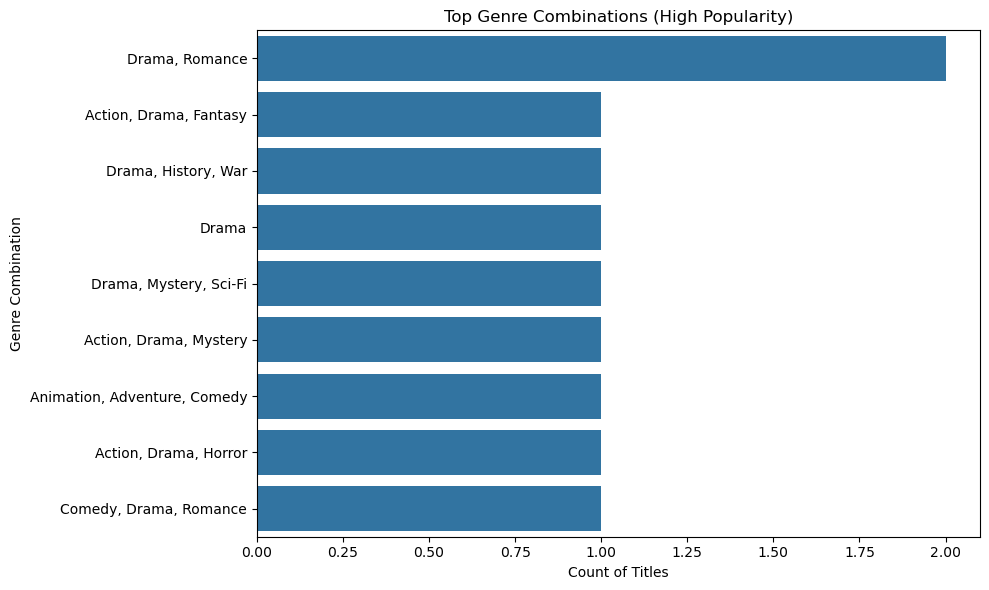

In [6]:
plt.figure(figsize=(10, 6))
# Define top_combos, it filters the DataFrame for high popularity titles and counts the occurrences of each genre combination, keeping only the top 10 combinations.
top_combos = df_tags[df_tags['popularity_band'] == 'High']['genre_list'].value_counts().head(10)
# Create a bar plot of the top genre combinations using x as the counts and y as the genre combinations.
sns.barplot(x=top_combos.values, y=top_combos.index)
plt.title('Top Genre Combinations (High Popularity)')
plt.xlabel('Count of Titles')
plt.ylabel('Genre Combination')
plt.tight_layout()
plt.show()

#### 5.2 IMDb Rating vs Popularity Band

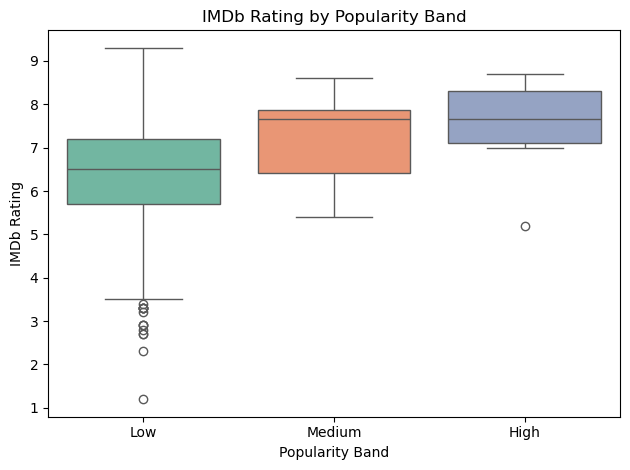

In [7]:
# define x as the popularity band and y as the IMDb rating, 
# using a box plot to visualize the distribution of IMDb ratings across different popularity bands.
sns.boxplot(data=df_tags, x='popularity_band', y='imdb_rating', palette='Set2', hue='popularity_band')
plt.title('IMDb Rating by Popularity Band')
plt.xlabel('Popularity Band')
plt.ylabel('IMDb Rating')
plt.tight_layout()
plt.show()


#### 6. Chi-Square Test: Primary Genre vs Popularity Band

- H₀: Primary genre and popularity band are independent
- H₁: There is an association between genre and popularity level


Contingency Table:
popularity_band           Low  Medium  High
primary_genre                              
Action                    591      10     3
Adventure                  79       1     0
Animation                 194       9     1
Anime                       9       1     0
Aventure                    1       0     0
Biography                  58       0     0
Children & Family Movies    0       1     0
Comedies                    1       0     0
Comedy                    556       9     1
Crime                     239       2     0
Documentary               237       0     0
Drama                     455       9     5
Family                      6       2     0
Fantasy                     5       0     0
Game-Show                  18       0     0
Horror                     44       0     0
Kids                        4       0     0
Music                       1       0     0
Musical                     1       0     0
Mystery                     2       0     0
Reality TV   

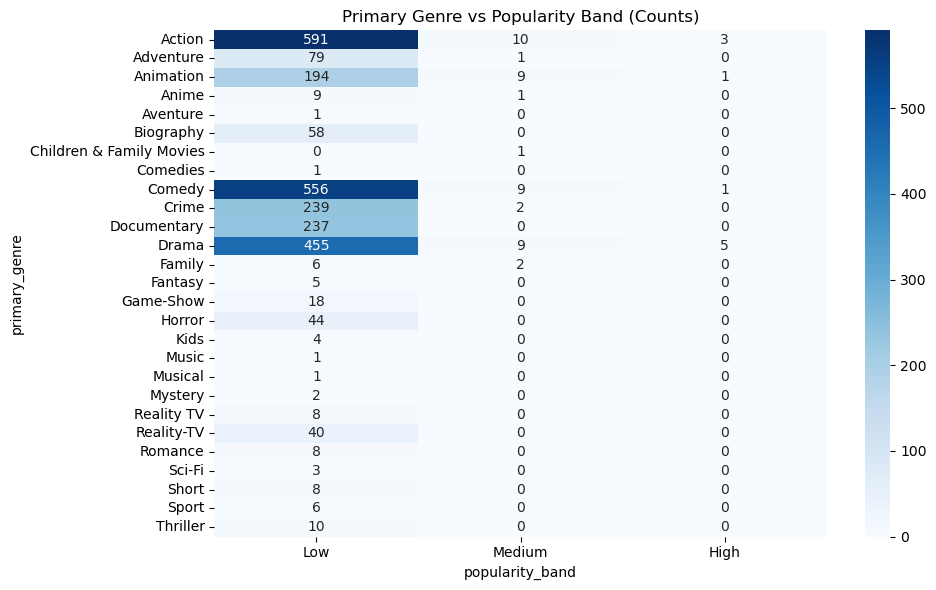

In [8]:
from scipy.stats import chi2_contingency

# Create a contingency table using crosstab to summarize the counts of primary genres across popularity bands.
# rows = primary_genre, columns = popularity_band, values = counts of titles that fall into each genre and popularity band.
chi_tbl = pd.crosstab(df_tags['primary_genre'], df_tags['popularity_band'])
# use the contingency table to perform the Chi-square test of independence.
chi2, p_val, dof, expected = chi2_contingency(chi_tbl)

print("Contingency Table:")
print(chi_tbl) 
# Print the Chi-square statistic and p-value to assess the independence between primary genre and popularity band.
print(f"\nChi-square statistic: {chi2}, p-value: {p_val}")

# Visualize
plt.figure(figsize=(10, 6))
sns.heatmap(chi_tbl, annot=True, fmt='d', cmap='Blues')
plt.title('Primary Genre vs Popularity Band (Counts)')
plt.tight_layout()
plt.show()

This heatmap shows which genres tend to dominate certain popularity bands. For example, if Action is most frequent in the High band, and that could influence Netflix's genre investment strategy.

#### Business Insight (Chi-Square)
A significant result suggests Netflix should prioritize certain genres to improve long-term Top 10 performance.
Therefore, since p < 0.05, Netflix may consider favoring genres that trend toward high popularity.

#### 7. ANOVA: IMDb Rating vs Primary Genre

- H₀: Mean IMDb ratings are equal across genres
- H₁: At least one genre differs in average rating

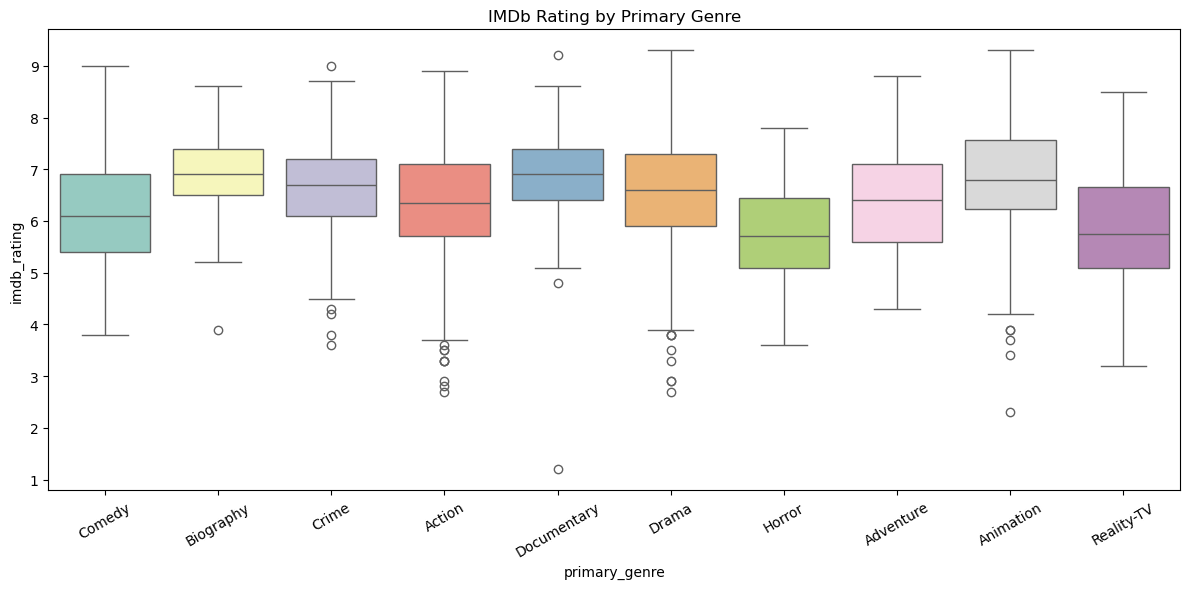

ANOVA F=19.233604413407477, p-value=2.0392925616139996e-31


In [ ]:
from scipy.stats import f_oneway # performs one-way ANOVA test

# Filter top 10 primary genres for clean boxplot
# To make the boxplot readable by focusing on the most represented genres.
top_genres = df_tags['primary_genre'].value_counts().head(10).index # we use .index to get the names of the top genres.
# Filter the DataFrame to include only the top genres for ANOVA
# We only want to compare popular genres with enough data to be meaningful in ANOVA.
anova_df = df_tags[df_tags['primary_genre'].isin(top_genres)]

# Boxplot
plt.figure(figsize=(12, 6))
# takes the filtered DataFrame with top genres and creates a boxplot of IMDb ratings by primary genre.
sns.boxplot(data=anova_df, x='primary_genre', y='imdb_rating', palette='Set3', hue='primary_genre')
plt.title('IMDb Rating by Primary Genre')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Perform ANOVA
# the first part dropna drops missing imdb values and then we group the DataFrame by primary genre.
groups = [g['imdb_rating'].dropna() for _, g in anova_df.groupby('primary_genre')]
# f-oneway performs the one-way ANOVA test on the *all groups of IMDb ratings for each primary genre.
f_stat, p_anova = f_oneway(*groups)
print(f"ANOVA F={f_stat}, p-value={p_anova}")


#### Business Insight (ANOVA)
- A significant result means IMDb ratings vary by genre — a useful insight when optimizing for high audience ratings.
- An IMDb rating is what the audience who have watched the show rate it.
- Comparing it to genre of a show, a significant p-value as above p < 0.05 tells us that the genre of a show affects the audience rating.
- Therefore, Netflix can prioritize which primary genres to use in a show as a way to increase that shows audience rating.

#### 8. Regression: IMDb Rating & Tags → Cumulative Popularity

- **H₀**: IMDb rating and genre tags cannot predict popularity (cumulative popularity) or longevity of a show.
- **H₁**: They significantly predict the cumulative weeks in Top 10 or longevity of a title.

In [ ]:
import statsmodels.api as sm

# Prepare regression inputs
# reg_vars are IMDb rating and binary genre tags.
reg_vars = ['imdb_rating'] + [col for col in df_tags.columns if col.startswith('tag_')]
X = df_tags[reg_vars] # explanatory variables are IMDb rating and binary genre tags
X = sm.add_constant(X) # explanatory variable is a constant term needed because OLS regression requires an intercept term.
y = df_tags['max_popularity'] # target variable is max_popularity or maximum cumulative weeks in top 10
# Fit OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         max_popularity   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     7.103
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           3.89e-32
Time:                        17:03:09   Log-Likelihood:                -5975.0
No. Observations:                2543   AIC:                         1.202e+04
Df Residuals:                    2507   BIC:                         1.223e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Business Insight (Regression)
- This model helps Netflix understand how each genre element and IMDb score contributes to a title's time in the Top 10.
- The regression coefficients provide quantifiable evidence to support investment in specific types of content.

#### 9. Final Conclusion

- Chi-Square confirms genre affects popularity distribution.
- ANOVA confirms rating expectations differ by genre.
- Regression quantifies how tags and IMDb drive success.
- Together, these results provide strong data-driven guidance for Netflix content strategy.